# Port-au-Prince Input Data Analysis 

### Authors: Carter Murphy, Nick Bourgeois, Mackenzie Kummer, Nolan Penoyer

## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from fitter import Fitter, get_common_distributions, get_distributions
from statsmodels.sandbox.stats.runs import runstest_1samp

## Reading the Data

In [2]:
aircraft_capabilities = pd.read_excel("AircraftCapabilities.xlsx")
aircraft_capabilities.head()

,AC,Capacity (sTon),Avg Load (sTon)
0,707,26.0,20.28
1,727,13.0,10.14
2,737,11.0,8.58
3,747,78.0,60.84
4,767,58.0,45.24


### Goes through all aircraft types, then lists the capacity (in tons) of each type of aircraft and the average load of each type of aircraft

In [4]:
ground_time = pd.read_excel("GroundTime.xlsx")
ground_time = ground_time.drop(ground_time.columns[[2,3]], axis=1)
ground_time.head()

,Gournd Time (Hrs),ID
0,1.872,2706
1,0.748,2707
2,1.454,2708
3,1.178,2709
4,1.202,2710


### Lists an ID for each plane that can be found in HFOCC data, and pairs the ground time (in hours) for every aircraft

In [6]:
hfocc = pd.read_excel("HFOCC.xlsx")
hfocc.head()

,Request Status,Arrival Date,Arrival Time,Organization,Aircraft Type,Call Sign,Tail #,A/C Size,Affiliation,Request ID,...,Nationality,Mission purpose,# Pax,CNX DATE,CNX TIME,AF Planner Remarks,AF Manager Remarks,ID,Modified,Created
0,Complete,2010-01-12,2100Z,DSWA LLC,LEARJET,N4009,N4009,N,NGO,TBD,...,UNITED STATES,MEDICAL SUPPLIES/MEDICAL PAX,UNK,NaN,NaN,JJ,NaN,2706,2010-02-06 15:22:56,2010-02-03 09:08:54
1,Complete,2010-01-15,1900Z,DOD,UNKNOWN,PAT141,Unknown,S,MIL,TBD,...,UNITED STATES,GA ARMY GUARD PAX & CARGO,2,NaN,NaN,NaN,NaN,2707,2010-02-11 10:36:54,2010-02-03 09:08:54
2,Complete,2010-01-16,0400Z,US SENATOR,GULFSTREAM,N450GD,N450GD,N,GOV,125,...,UNITED STATES,PICK UP EVACUEES,14,NaN,NaN,NaN,NaN,2708,2010-02-06 15:01:10,2010-02-03 09:08:54
3,Complete,2010-01-16,0900Z,DoD (612),UNKNOWN,SHARK94,Unknown,N,MIL,F319,...,UNITED STATES,CARGO OUT/AM DIV SHUTTLE,UNK,NaN,NaN,NaN,NaN,2709,2010-02-07 08:20:31,2010-02-03 09:08:54
4,Complete,2010-01-16,1000Z,1 SOW,C130,RCH1031,UNKNOWN,N,MIL,159,...,UNITED STATES,MEDICAL SUPPLIES,5,NaN,NaN,NaN,NaN,2710,2010-02-11 13:24:41,2010-02-03 09:08:54


### Lots of unnecessary data, lets us know the Id of plane and what type of plane it is. Also tells us the arrival time and arrival date. Also whether the plane actually arrived 

In [7]:
data = [['13 Jan-28 Jan',390,290,250,700],['29 Jan-28 Feb',195,145,125,200]]
daily_demand = pd.DataFrame(data,columns=['Dates','Water','Food','Medical','Logistics'])
daily_demand

,Dates,Water,Food,Medical,Logistics
0,13 Jan-28 Jan,390,290,250,700
1,29 Jan-28 Feb,195,145,125,200


### Lists the average daily demand (in tons) of water, food, medical supplies, and logistics over the specified dates

## Analysis of Ground Time Data

### Continous or Discrete?

In [10]:
ground_time.dtypes

Gournd Time (Hrs)    float64
ID                     int64
dtype: object

#### The two columns in this data list the ground time for every aircraft that landed at Port-au-Prince airport, and the aircraft ID that goes with each aircraft. As seen above python has listed the ground time variable as a float object, while the ID variable is listed as an integer object. Further for the ground time variable, time is always modeled as a continuous variable. Therefore it is safe to assume that the ground time column will follow a continous distribution. 

### Check for Homogeneity

In [12]:
grnd_time = ground_time['Gournd Time (Hrs)'].values
grnd_time

array([1.872, 0.748, 1.454, ..., 1.668, 1.237, 1.703])

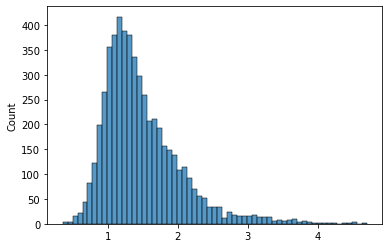

In [14]:
sns.histplot(grnd_time)
plt.show()

#### The data follows one distribution with a mean of roughly 1.2 hours. However the data is skewed to the right. Despite the skewness in the data, it is still in fact homogenous. 

### Check for Stationarity

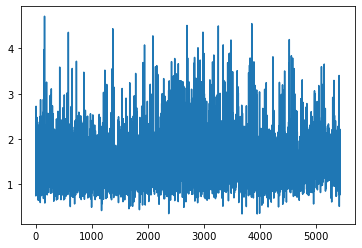

In [15]:
plt.plot(grnd_time)
plt.show()

#### Within the plot above the data does not really trend with time. Meaning it follows a similar pattern throughout the whole plot. Also the data shows a relatively constant variance throughout the plot. There are a quite a few spikes in the data, but they don't seem to occur in any sort of pattern. So these instances can be modeled as outliers in the dataset. Therefore the data for ground time for each aircraft at Port-au-Prince airport is stationary. 

### Check for Independence using a Turning Points Test

In [18]:
def turning_points_test(x):
    dx = np.diff(x)
    return np.sum(dx[1:] * dx[:-1] < 0)

In [20]:
turns = turning_points_test(grnd_time)
turns

3627

#### Mean 

In [24]:
Mean_R = ((2*len(grnd_time))-4) / 3
Mean_R

3621.3333333333335

#### Standard Deviation

In [25]:
Sigma_R2 = ((16*len(grnd_time))-29) / 90
Sigma_R2

965.7222222222222

#### Test Statistic

In [28]:
test_stat = (turns - Mean_R) / math.sqrt(Sigma_R2)
test_stat

0.18234823084939997

#### H_O : The data is independent 
#### H_A : The data is not independent

In [29]:
if test_stat < stats.norm.ppf(0.025) or test_stat > stats.norm.ppf(0.975):
    print("Reject the null hypothesis that the data is independent")
else:
    print("Fail to reject the null hypothesis that the data is independent")

Fail to reject the null hypothesis that the data is independent


### Check for Independence using a Runs Test about the Mean

In [34]:
runs_test = runstest_1samp(x=grnd_time,cutoff='mean')
runs_test

(-5.090924845003865, 3.5632124750306147e-07)

In [35]:
if runs_test[0] < stats.norm.ppf(0.025) or runs_test[0] > stats.norm.ppf(0.975):
    print("Reject the null hypothesis that the data is independent")
else:
    print("Fail to reject the null hypothesis that the data is independent")

Reject the null hypothesis that the data is independent


#### In the turning points test we failed to reject the null hypothesis, meaning that we concluded the data is independent. Then in the runs test about the mean we rejected the null hypothesis, so in that test we concluded that the data was not independent. However, the runs test is defined as a hypothesis test that checks the randomness in the data. Therefore our second conclusion to reject the null hypothesis makes more sense. The data is not really from a random process, once every aircraft landed it was timed and then added to the data once it left the airport. Therefore because the data passed the turning points test, the ground time data is independent. 

### Ground Time data is Indpendently and Identically Distributed (IID)

#### January 16th at 0900 10 more ground crews per day can be flown into the airport. 